[Link](https://www.kaggle.com/competitions/digit-recognizer/data) to Competition

In [2]:
#|default_exp app

In [3]:
#| export
import os
from pathlib import Path
import pandas as pd
import numpy as np
from fastai.vision.all import *
from fastai.vision.all import Image
from torchvision.utils import save_image

matplotlib.rc('image', cmap='Greys')

In [4]:
#| export
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = ''

In [5]:
#| export
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
#| export
path = Path('digit-recognizer')

In [7]:
#| export
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [8]:
#| export
if iskaggle:
    path = Path('../input/digit-recognizer')
    ! pip install -q dataset

For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:

`ImageId,Label`<br>
`1,3`<br>
`2,7`<br>
`3,8` <br>
`(27997 more lines)`<br>

Import Training Set

In [9]:
#| export
train_full = pd.read_csv(path/'train.csv')

In [10]:
#| export
label = train_full.iloc[:, :1]

In [11]:
#| export
image_df = train_full.iloc[:, 1:]

In [12]:
image_df.shape

(42000, 784)

In [13]:
#| export
np_image_array = image_df.values
np_image_array, np_image_array.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 (42000, 784))

In [14]:
#| export
image_tens = [tensor(x).float() for x in np_image_array]

In [15]:
#| export
stacked_img_tens = torch.stack(image_tens).float()/255

In [16]:
#| export
stacked_lable_tens = tensor(label).unsqueeze(1)

In [17]:
# img = stacked_img_tens[0].reshape(28, 28)
# save_image(img, './test.png')

In [18]:
#| export
folder_path = Path('train')
if not folder_path.exists():
    folder_path.mkdir()
for i in range(stacked_img_tens.shape[0]):
    img = stacked_img_tens[i].reshape(28, 28)
    dest = (folder_path/label['label'][i].astype(str))
    dest.mkdir(exist_ok=True)
    img_path = Path(f"{dest}/{i}.png")
    if not img_path.exists():
        save_image(img, img_path)

In [19]:
#| export
dls = ImageDataLoaders.from_folder(folder_path, get_image_files(folder_path), bs=255, valid_pct=0.2, seed=42, label_func=parent_label)

In [20]:
#| export
learn = vision_learner(dls, resnet18, loss_func=F.cross_entropy, metrics=accuracy)

/home/petewin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/petewin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
learn.fine_tune(3, base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.546223,0.837224,0.742143,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.516394,0.249551,0.922857,00:22
1,0.211792,0.152949,0.954881,00:21
2,0.119614,0.142283,0.957619,00:21


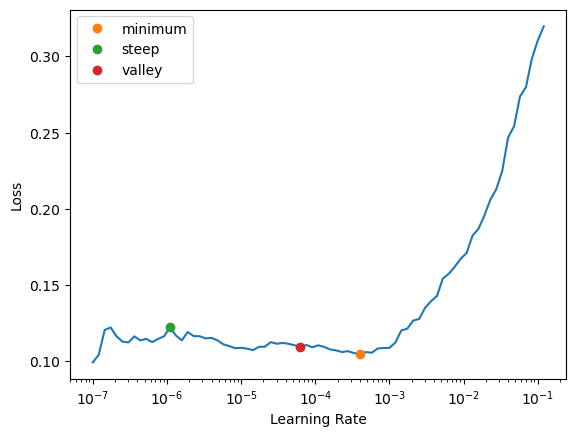

In [22]:
#| export
lr_min, lr_steep, lr_valley = learn.lr_find(suggest_funcs=(minimum, steep, valley))

In [ ]:
#| export
lr_min = f"{lr_min:.2e}"
lr_steep = f"{lr_steep:.2e}"
lr_valley = f"{lr_valley:.2e}"

In [ ]:
#| export
learn = vision_learner(dls, resnet18, loss_func=F.cross_entropy, metrics=accuracy)

In [ ]:
import nbdev
nbdev.export.nb_export('mnist_classifier.ipynb', 'app')
print('Export successful')